# deep lab w/ youtube-dl

welcome, this colab notebook will try its best to split any youtube video in two

once everything has finished running you will find 3 new files in the root of your google drive `src.mp4`, `fg.mp4`, and `bg.mp4`

## instructions
make sure you are using the GPU in your runtime and that you are connected, there should be a green checkmark in the top-right corner that says `CONNECTED`
- in the top menu under runtime select `Change runtime type`
- make sure it says `GPU` for the "Hardware Accelerator" dropdown

for each cell after this one
- fill in any required inputs
- click on the play button in the top left corner to run the cell and wait for it to finish
  - if you dont see a play button, you must select the cell first either by clicking on it or by navigating to it with the up/down arrow keys


## notes
this will take a while..

google limits colab notebook execution to 12 hours runtime, keep this in mind since it took me around 30 minutes to run everything for a 1 minute long 720p video

feel free to modify (see license below)

if you get a popup complaining about resource usage you can safely ignore it

## references
this wouldn't work without 

[DeepLab: Deep Labelling for Semantic Image Segmentation](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md), this notebook is modeled after their example

[youtube-dl](https://github.com/rg3/youtube-dl)

[ffmpeg](http://ffmpeg.org/)

##  MIT License

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [0]:
#@title import/install the libraries we will need {display-mode: "form"}

! pip install tqdm > /dev/null

import os
import StringIO
import tarfile
import tempfile
import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np

np.warnings.filterwarnings('ignore')

from PIL import Image

import tensorflow as tf
import scipy.misc as sm

# from google.colab import files
from googleapiclient.http import MediaFileUpload

import shutil
from tqdm import tqdm


print('all imports finished')

In [0]:
#@title setup helper methods {display-mode: "form"}


class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


def split_it_out(f_no):
	with open('./all_frames/{}'.format(f_no), 'rb') as imgfile:
	    img = Image.open(imgfile)
	    og_img = np.asarray(img)
	    resized_im, seg_map = MODEL.run(img)

	    xx = label_to_color_image(seg_map)
	    big_label = sm.imresize(xx, og_img.shape, 'nearest')

	    fg_alpha = np.sum(big_label, axis=2).astype(np.bool).astype(np.uint8) * 255
	    bg_alpha = 255 - fg_alpha

	    fg_img = np.dstack((og_img, fg_alpha))
	    bg_img = np.dstack((og_img, bg_alpha))

	    sm.imsave("./processed/fg/{}".format(f_no), fg_img)
	    sm.imsave("./processed/bg/{}".format(f_no), bg_img)

      
def split_it_out_person(f_no):
    with open('./all_frames/{}'.format(f_no), 'rb') as imgfile:
        img = Image.open(imgfile)
        og_img = np.asarray(img)
        _, seg_map = MODEL.run(img)

        ppl = (seg_map == 15)
        big_label = sm.imresize(ppl.astype(np.uint8), og_img.shape, 'nearest')

        fg_alpha = big_label * 255
        bg_alpha = 255 - fg_alpha

        fg_img = np.dstack((og_img, fg_alpha))
        bg_img = np.dstack((og_img, bg_alpha))

        sm.imsave("./processed/fg/{}".format(f_no), fg_img)
        sm.imsave("./processed/bg/{}".format(f_no), bg_img)
        
def upload_to_drive(src_path, f_name):
  media = MediaFileUpload(src_path)

  file_metadata = {
    'name': f_name,
  }

  created = drive_service.files().create(body=file_metadata,
                                         media_body=media,
                                         fields='id').execute()
  print('done uploading {}'.format(f_name))
      
for p in ['./all_frames', './processed', './processed/bg', './processed/fg']:
	if not os.path.exists(p):
		os.mkdir(p)
    
print('done !')

In [0]:
#@title pick a model (mobilenets run quicker but xceptions produce better results) {display-mode: "form"}

MODEL_NAME = 'xception_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print 'downloading model, this may take a while...'
urllib.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print 'download completed! loading DeepLab model...'

MODEL = DeepLabModel(download_path)
print 'model loaded successfully!'

running deeplab on image https://media.wired.com/photos/5ab25aed5d6b7160f7e1850e/master/w_440,c_limit/GettyImages-860273932.jpg...


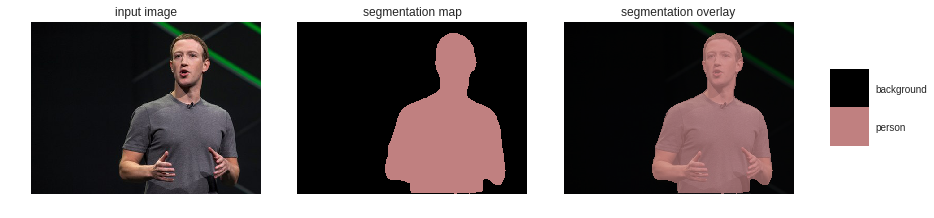

In [0]:
#@title (optional) try out the model {display-mode: "form"}


IMAGE_URL = 'https://media.wired.com/photos/5ab25aed5d6b7160f7e1850e/master/w_440,c_limit/GettyImages-860273932.jpg'  #@param {type:"string"}


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.urlopen(url)
    jpeg_str = f.read()
    orignal_im = Image.open(StringIO.StringIO(jpeg_str))
  except IOError:
    print 'Cannot retrieve image. Please check url: ' + url
    return

  print 'running deeplab on image %s...' % url
  resized_im, seg_map = MODEL.run(orignal_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL
run_visualization(image_url)

In [0]:
#@title connect to google drive {display-mode: "form"}
from google.colab import auth
auth.authenticate_user()

In [0]:
#@title install everything else {display-mode: "form"}
print('installing youtube-dl')
! curl --silent -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
! chmod a+rx /usr/local/bin/youtube-dl > /dev/null
print('updating packages')
! apt-get -qq update -y > /dev/null
print('installing ffmpeg')
! apt-get -qq install ffmpeg -y > /dev/null

print('done !')

In [0]:
#@title download your youtube video {display-mode: "form"}
youtube_url = "https://www.youtube.com/watch?v=" #@param {type:"string"}

! youtube-dl -o "to_split.mp4" $youtube_url

## ready for final step
check the box in the cell below if your video has real live people you want to extract on their own

this will take a while, you do not need to do anything else

In [0]:
#@title run everything {display-mode: "form"}
has_people = True #@param {type:"boolean"}

split_fun = split_it_out_person if has_people else split_it_out

print('extracting frames...')
! ffmpeg -loglevel panic -i to_split.mp4 "./all_frames/$filename%04d.png"


print('processing frames...')
interrupt = False

all_fn = os.listdir('./all_frames')
for i in tqdm(range(len(all_fn))):
    try:
        split_fun(all_fn[i])
    except KeyboardInterrupt:
        print('\ncya')
        interrupt = True
        break
    except:
        print('oops {}'.format(all_fn[i]))
        
if not interrupt:
  print('stitching the frames back together...')
  !ffmpeg -loglevel panic -i "./processed/fg/%04d.png" -vcodec png fg.mp4 -y
  !ffmpeg -loglevel panic -i "./processed/bg/%04d.png" -vcodec png bg.mp4 -y

  print('uploading your results to google drive...')

  from googleapiclient.discovery import build
  drive_service = build('drive', 'v3')

  for snf in [('to_split.mp4', 'src.mp4'), ('fg.mp4', 'fg.mp4'), ('bg.mp4', 'bg.mp4')]:
    upload_to_drive(*snf)

  print('finished !')